# Diabetes data

In [3]:
import numpy as np
import scipy.stats as ss
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [4]:
ds1 = sm.datasets.get_rdataset("Pima.tr", package="MASS")   # datasets from MASS library in R
ds2 = sm.datasets.get_rdataset("Pima.te", package="MASS")   # tr for training and te for test
# print(ds1.__doc__)

df = pd.concat([ds1.data,ds2.data])
df.shape

(532, 8)

## Dataset fields

``npreg`` number of pregnancies.

``glu``     plasma glucose concentration in an oral glucose tolerance test.

``bp``      diastolic blood pressure (mm Hg).

``skin``    triceps skin fold thickness (mm).

``bmi``     body mass index (weight in kg/(height in m)^2).

``ped``     diabetes pedigree function.

``age``      age in years.

``type``    ``Yes`` or ``No``, for diabetic according to WHO criteria.

## Exploratory data analysis

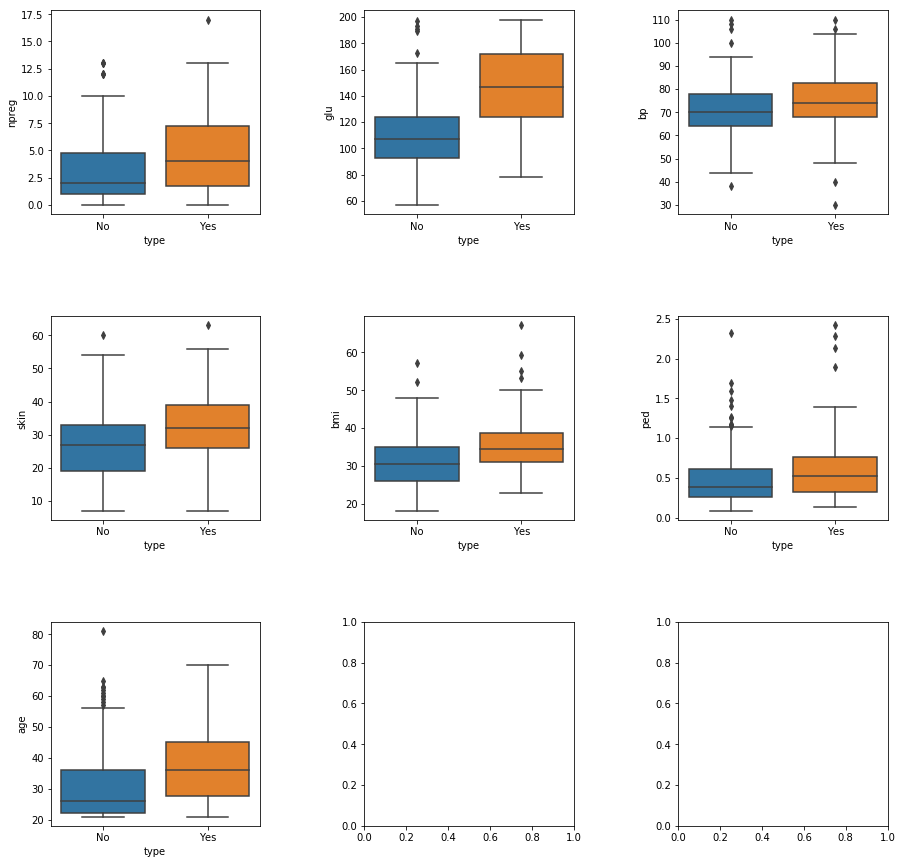

In [7]:
fig, axes = plt.subplots(3,3,figsize=(15,15))
fig.subplots_adjust(wspace=0.5,hspace=0.5)

for i, axes in enumerate(fig.axes):
    if (i <= 6):
        _ = sns.boxplot(data=dtrain,x="type",y=dtrain.columns[i], ax=axes)


## Data preparation

In [5]:
# Splitting the data set into training and test sets
np.random.seed(123456)

nrows = df.shape[0]
f=2/3

ntrain = int(f*nrows) ; ntest = nrows - ntrain

v1 = np.random.choice(nrows,size=ntrain,replace=False)
v2 = np.setdiff1d(np.arange(nrows),v1)

dtrain = df.iloc[v1,:] 
dtest = df.iloc[v2,:]

# Naive Bayes Classification

Wikipedia article on [NB Classification](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) is very good

In [8]:
# scikit-learn implementation of Naive Bayes classifier
from sklearn import naive_bayes

gnb = naive_bayes.GaussianNB()
gnbfit = gnb.fit(dtrain.iloc[:,range(7)],dtrain["type"])

yhat = gnbfit.predict(dtest.iloc[:,range(7)])


In [9]:
(yhat != dtest["type"]).sum()/dtest.shape[0]

0.21910112359550563

In [10]:
# Gaussian naive bayes implementation
# If x is the vector of test case features,for each class Ck we need
# P(Ck|x) ~ P(Ck) * Prod(P(xi|Ck)), assuming that xi is distributed normally conditional on Ck
# Note: P(xi|Ck) is actually a probability density
# Decision rule: Predicted class is one for which P(Ck|x) is the largest

def GNB2(dtest,dtrain,ClassVar):

    Counts = dtrain.groupby(ClassVar)[ClassVar].count()
    nClasses = len(Counts)
    PC = Counts/np.sum(Counts)
    
    mu = dtrain.groupby(ClassVar).mean().to_numpy()
    sigma = dtrain.groupby(ClassVar).std().to_numpy()
    
    TestCases = dtest.drop(columns=ClassVar)
    PredClasses = []
    for j in range(TestCases.shape[0]):
        x = TestCases.iloc[j]
        MaxProb = 0
        for k in range(nClasses):       
            PProd = 1 
            for i in range(len(x)):
                z = (x[i]-mu[k,i])/sigma[k,i]
                PxiCk = ss.norm.pdf(z)
                PProd = PxiCk * PProd
        
            PCkx = PC[k] * PProd
            if (PCkx >= MaxProb):
                Pred = PC.index[k]
                MaxProb = PCkx
                
        PredClasses.append(Pred)        
        
    return(PredClasses)    

In [11]:
res2 = GNB2(dtest,dtrain,'type')
(res2 != dtest["type"]).sum()/dtest.shape[0]

0.24719101123595505

# Logistic regression

In [28]:
# First, we try the sklearn implementation
from sklearn.linear_model import LogisticRegression
X = dtrain.drop(columns='type').to_numpy()
y = dtrain.loc[:,['type']].to_numpy().flatten()

lrfit = LogisticRegression(solver='lbfgs').fit(X,y)
betas = lrfit.coef_
betas

X2 = dtest.drop(columns='type').to_numpy()
lrpred = lrfit.predict(X2)
(lrpred != dtest["type"]).sum()/dtest.shape[0]

array([[ 0.11698487,  0.03511303, -0.01344156,  0.00271843,  0.10140572,
         0.54380539,  0.02305075]])

0.25280898876404495

In [46]:
lrpred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [40]:
# statsmodels seems to provide a lot more detail

X = dtrain.drop(columns='type').to_numpy()
y = dtrain.loc[:,['type']].to_numpy()

X1 = sm.tools.add_constant(X)
Classes,y1 = np.unique(y,return_inverse=True)     # Encoding response variable


smlr = sm.Logit(y1,X1)
results = smlr.fit()

Optimization terminated successfully.
         Current function value: 0.442320
         Iterations 6


In [44]:
type(results)

statsmodels.discrete.discrete_model.BinaryResultsWrapper

In [42]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  354
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            7
Date:                Thu, 18 Jul 2019   Pseudo R-squ.:                  0.3093
Time:                        17:40:55   Log-Likelihood:                -156.58
converged:                       True   LL-Null:                       -226.69
Covariance Type:            nonrobust   LLR p-value:                 4.590e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1680      1.196     -7.663      0.000     -11.513      -6.823
x1             0.1182      0.053      2.213      0.027       0.014       0.223
x2             0.0351      0.005      7.029      0.0

In [81]:
X2 = dtest.drop(columns='type').to_numpy()
X2 = sm.tools.add_constant(X2)
pX2 = results.predict(exog=X2)
ptest = np.where(pX2 >= 0.0, 'Yes', 'No')

In [80]:
for cutoff in [0.1*x for x in range(11)]:
    ptest = np.where(pX2 >= cutoff, 'Yes', 'No')
    MisLabeled = (ptest != dtest["type"]).sum()
    Fraction = MisLabeled / dtest.shape[0]
    print('{:.2f}   {:d}   {:.2f}'.format(cutoff, MisLabeled, Fraction))
        

0.00   121   0.68
0.10   74   0.42
0.20   53   0.30
0.30   43   0.24
0.40   43   0.24
0.50   45   0.25
0.60   40   0.22
0.70   41   0.23
0.80   48   0.27
0.90   51   0.29
1.00   57   0.32


## Small example
        

In [100]:
df = dtrain.iloc[0:20,list(range(1,5))+[7]]

X = df.drop(columns='type').to_numpy()
y = df['type'].to_numpy()

X = sm.tools.add_constant(X)
y = np.unique(y,return_inverse=True)[1]    # Encoded values for the class


In [109]:
m1 = sm.Logit(y,X)
m1res = m1.fit()
print(m1res.summary())
m1res.params

Optimization terminated successfully.
         Current function value: 0.304079
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   20
Model:                          Logit   Df Residuals:                       15
Method:                           MLE   Df Model:                            4
Date:                Thu, 18 Jul 2019   Pseudo R-squ.:                  0.5022
Time:                        22:13:11   Log-Likelihood:                -6.0816
converged:                       True   LL-Null:                       -12.217
Covariance Type:            nonrobust   LLR p-value:                   0.01544
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6047      9.312     -1.139      0.255     -28.855       7.646
x1             0.0818      0.

array([-10.60469386,   0.08179691,  -0.08352366,   0.05637251,
         0.11167211])

In [112]:
# Trick to search through values
dir(m1res)
m1res.pvalues

array([0.25476536, 0.04901545, 0.49839004, 0.58469005, 0.66971653])

In [124]:
def sigmoid(x):
    x = np.asarray(x)
    return(1/(1+np.exp(-x)))

array([0.73105858, 0.88079708, 0.95257413])